# This notebook provides interactive widgets to play with the imaging requirements for the SKA1 SDP

## First, do the necessary set-up (run the code block below, first)

In [1]:
""" These first few lines below import the IPython definitions and methods that we will use. 
Please Refer to ipython_api.py for the implementation """
from IPython.html.widgets import interact, interactive, fixed
from IPython.html.widgets.interaction import interact_manual
from IPython.html import widgets
from api_ipython import IPythonAPI as iapi
from parameter_definitions import *
from implementation import Implementation as imp
import sympy.physics.units as u

%matplotlib inline

# The lines below define the available telescopes, bands and modes that may be chosen.

available_teles = (Telescopes.SKA1_Low, Telescopes.SKA1_Low_old, Telescopes.SKA1_Mid, Telescopes.SKA1_Mid_old, 
                   Telescopes.SKA1_Sur_old, Telescopes.SKA2_Low, Telescopes.SKA2_Mid)
available_bands = (Bands.Low, 
                   Bands.Mid1, Bands.Mid2, Bands.Mid5A, Bands.Mid5B, 
                   Bands.Sur1)
available_modes = (ImagingModes.Continuum, ImagingModes.Spectral, ImagingModes.SlowTrans, ImagingModes.CSS)
verbose_display = True

:0: FutureWarning: IPython widgets are experimental and may change in the future.


## Testing the new 2D "parameter sweep" functionality. Not yet fully implemented.

In [3]:
from IPython.display import display, HTML

telescope = Telescopes.SKA1_Low
band = Bands.Low
immode = ImagingModes.Spectral
expression = 'Rflop'
parameters = ('Na', 'Bmax')
unit_strings = (None, 'u.km')
parameter_ranges = ((100,512),(40,70))
number_steps = 2
verbose = False

display(HTML('<font color="blue">Computing the result -- this may take several (tens of) seconds.</font>'))
(p1_values, p2_values, results) = iapi.eval_param_sweep_2d(telescope, immode, band=band, 
                                                           expression=expression, parameters=parameters, 
                                                           params_ranges=parameter_ranges, number_steps=number_steps, 
                                                           unit_strings=unit_strings, verbose=verbose)
#header = 'Plotting  Number of FLOPS for %s in %s mode as a function of %s' % (telescope, immode, parameter)
#iapi.plot_line_datapoints(header, param_values, results)
print '-=- results -=-'
print results

Evaluating expression Rflop while
sweeping parameters Na and Bmax over 2D doman [100, 512] x [40, 70] in 2 steps each,
for a total of 9 data evaluation points
done with parameter sweep!
-=- results -=-
[[  1.17800116e+14   1.71171419e+14   2.21148568e+14]
 [  4.63048472e+14   7.16126085e+14   9.27107857e+14]
 [  9.51898489e+14   1.37943290e+15   1.80403176e+15]]


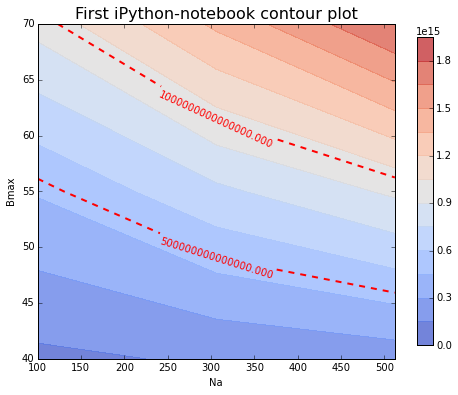

In [13]:
iapi.plot_2D_surface('First iPython-notebook contour plot', p1_values, p2_values, results, xlabel=parameters[0], 
                     ylabel=parameters[1],contours=np.array((5e14, 1.0e15)))

## Testing the new 1D "parameter sweep" functionality. Not yet fully implemented.

Starting sweep of parameter Bmax, evaluating expression Rflop over range (40, 80) in 5 steps (i.e. 6 data points)
>>> Evaluating for Bmax = 40000*m
>>> Evaluating for Bmax = 48000*m
>>> Evaluating for Bmax = 56000*m
>>> Evaluating for Bmax = 64000*m
>>> Evaluating for Bmax = 72000*m
>>> Evaluating for Bmax = 80000*m
done with parameter sweep!


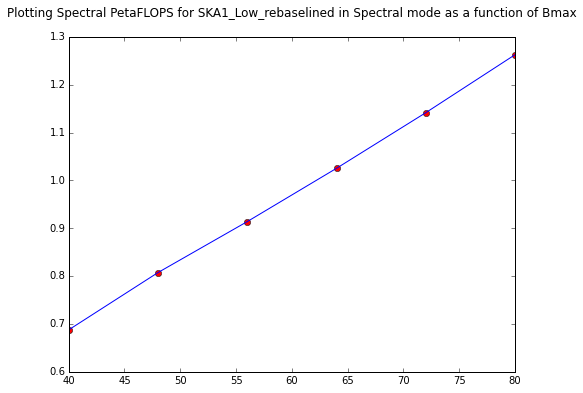

In [2]:
from IPython.display import display, HTML

expression = 'Rflop'
parameter = 'Bmax'
param_val_min = 40
param_val_max = 80
unit_string = "u.km"
number_steps = 5
telescope = Telescopes.SKA1_Low
immode = ImagingModes.Spectral

display(HTML('<font color="blue">Computing the result -- this may take several (tens of) seconds.</font>'))
(param_values, results) = iapi.eval_param_sweep_1d(telescope, immode, band=Bands.Mid1, 
                                                   expression='Rflop', parameter=parameter, param_val_min=param_val_min,
                                                   param_val_max=param_val_max, number_steps=number_steps, 
                                                   unit_string=unit_string, verbose=False)
header = 'Plotting Spectral PetaFLOPS for %s in %s mode as a function of %s' % (telescope, immode, parameter)
iapi.plot_line_datapoints(header, param_values, np.array(results)/u.peta)


## Using default values, we can compare telescopes side-by-side

Telescope,SKA1_Mid_old,SKA1_Mid_rebaselined,
Band,Mid1,Mid1,
Mode,Summed (Cont+Spec+Slow),Summed (Cont+Spec+Slow),
Baseline Dependent Time Avg.,False,False,
Max Baseline,200,150,km
Max # channels,n/a,n/a,
Optimal Number of Facets,n/a,n/a,
Optimal Snapshot Time,n/a,n/a,sec.
Visibility Buffer,217,26.1,PetaBytes
Working (cache) memory,106,20.2,TeraBytes
Image side length,71305,55673,pixels


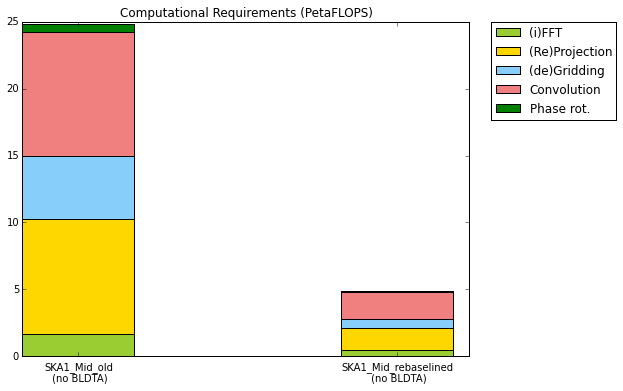

In [9]:
Tel1_BLDTA = False  #baseline dependent time averaging (initial default value, can be toggled interactively)
Tel2_BLDTA = False
interact_manual(iapi.compare_telescopes_default, 
                Telescope_1=available_teles, Telescope_2=available_teles, Band_1=available_bands,
                Band_2=available_bands, Mode_1=available_modes, Mode_2=available_modes,
                Tel1_BLDTA=Tel1_BLDTA, Tel2_BLDTA=Tel2_BLDTA, verbose=verbose_display);

## We can also interactively play with parameters (via sliders)

### The first option is automatic updating of results as the sliders are moved. This may be sluggish

In [3]:
BL_dep_time_av = False  #baseline dependent time averaging (initial default value, can be toggled interactively)
interact(iapi.evaluate_telescope_manual, max_baseline=(10,200), Nf_max = (1,256000,1), Nfacet=(1,10,1), Tsnap=(1.2,1800), 
         Telescope=available_teles, Band=available_bands, Mode=available_modes, BL_dep_time_av=BL_dep_time_av, 
         verbose=verbose_display);

Max Baseline,75 km
Max # of channels,128000
Telescope,SKA1_Low_rebaselined
Band,Low
Mode,Spectral
Tsnap,900.6 sec
Nfacet,5


Visibility Buffer,29.6 PetaBytes
Working (cache) memory,0.751 TeraBytes
Image side length,3715 pixels
I/O Rate,42.9 TeraBytes/s
Total Compute Requirement,8.83 PetaFLOPS
-> Gridding,0.385 PetaFLOPS
-> FFT,0.00893 PetaFLOPS
-> Projection,0.0603 PetaFLOPS
-> Convolution,8.27 PetaFLOPS
-> Phase Rotation,0.107 PetaFLOPS


### The second option is manual triggering of recompute events (recommended). 

#### This allows more conveniently computing elaborate (slow) optimizations and visualizations per computation, as these are only run when required
#### In this example, *Tsnap and Nfacet* are *automatically* chosen so as to minimize the value of Rflop

Max Baseline,75 km
Max # of channels,128000
Telescope,SKA1_Low_rebaselined
Band,Low
Mode,Continuum


>>>> 1. tp.Bmax = 80000*m
>>>> 2. tp.Bmax = 75000*m
Npix_linear, per facet 31348.976505015/N_facet
Dump time:  0.64*s
NOT IMPLEMENTING BASELINE DEPENDENT TIME AVERAGING
Tdump_predict = 0.64*s
Tdump_backward = Min(60.0*s, 0.64*N_facet*s)
Rflop fft  98275832791198.6*f_bin*log(31348.976505015/N_facet)/(T_snap*log(2))
>>>> 3. tp.Bmax = 75000*m
>>> Evaluating for Bmax = 75000*m
Evaluating Nfacets = 1
Tsnap has been optimized as : 26.545449. (Cost function = 0.986047)
Evaluating Nfacets = 2
Tsnap has been optimized as : 44.316468. (Cost function = 0.641749)
Evaluating Nfacets = 3
Tsnap has been optimized as : 58.412703. (Cost function = 0.776672)

Expression increasing with number of facets; aborting exploration of Nfacets > 3

0.641749 PetaFLOPS was the lowest FLOP value, found for (Nfacet, Tsnap) = (2, 44.32)


Optimal Number of Facets,2
Optimal Snapshot Time,44.3 sec.
Visibility Buffer,1.05 PetaBytes
Working (cache) memory,0.103 TeraBytes
Image side length,15674 pixels
I/O Rate,1.07 TeraBytes/s
Total Compute Requirement,0.642 PetaFLOPS
-> Gridding,0.116 PetaFLOPS
-> FFT,0.0309 PetaFLOPS
-> Projection,0.177 PetaFLOPS
-> Convolution,0.314 PetaFLOPS


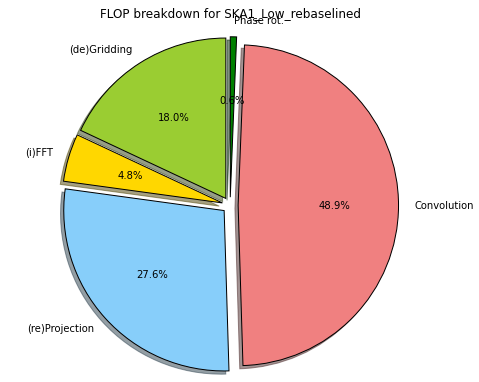

In [2]:
BL_dep_time_av = False  #baseline dependent time averaging (initial default value, can be toggled interactively)
interact_manual(iapi.evaluate_telescope_optimized, max_baseline=(10,200), Nf_max = (1,256000,1), Telescope=available_teles, 
         Band=available_bands, Mode=available_modes, BL_dep_time_av=BL_dep_time_av, verbose=verbose_display);